# A Deep Learning Approach to Limit Order Book Forecasting
By Aric Cutuli<br>
***

## Opening Remarks
The enigma concerning the predictability of markets has always been the principal driver of my interest in finance, and it inpires my ongoing exploration of machine learning's applications within the analysis and forecasting of financial time series. Today, we compare the performance of a studied deep learning model for limit order book forecasting on two stationary representations of the limit order book.

## Abstract
In this notebook, we implement an artificial neural network originally employed by Zhang et al[<sub>[1]</sub>](#ref1) that combines convolutional neural networks (CNNs) and a long short-term memory (LSTM) neural network in order to classify future directions of an order book at a high frequency. Specifically, given Coinbase order book data for Bitcoin, we seek to predict whether the mid price increases, decreases, or does not change in the next observation of the time series. Unlike Zhang et al's papers we reference[<sub>[1]</sub>](#ref1)[<sub>[2]</sub>](#ref2), which use non-stationary order book states as inputs to the network, our instantiation of the architecture is trained on order flow and order flow imbalance, which are stationary quantities derived from the limit order book[<sub>[3]</sub>](#ref3). Hence, this discussion also draws heavy inspiration from a 2021 article by Kolm et al[<sub>[4]</sub>](#ref4), which demonstrated that forecasting using order flow significantly outperforms raw order book inputs. Today, we further this discussion by doing an analysis of the impact that differencing order flow into order flow imbalance has on the forecasting performance of the model. We also approach the problem from a time series modeling perspective by analyzing the time-lag of the processes, a procedure that was not explicitly documented in those papers. We find that for our sparse data, the models are similarly poor in their ability to predict downward moves, but the model trained on order flow significantly outperforms the other when it comes to predicting upward moves. In the trading scenario we posit, we see that this failure to precisely predict downward moves is troublesome for intraday trading in a bearish market.

## Order Books, Flow, and Imbalance
Today's trading of equities and other securities is often facilitated by a [*limit order book*](https://en.wikipedia.org/wiki/Order_book), also known as an *order book*. The order book collects bids and offers made by prospective buyers and sellers and determines which incoming orders get executed and which are added to the book. The *bid price* is the highest price buyers are prepared to buy at, and the *ask price* is the lowest price sellers are willing to sell at. The *mid price*, which our model seeks to predict moves in, is the midpoint of the bid price and the ask price.

An order is defined by its side, quantity demanded, price to trade at, and time of submission. As one enters the system, the matching engine of the exchange tries to match the order with existing orders in the book. Orders that match are executed and called *market orders*, and orders that do not match or only partially match are added to the book and called *limit orders*.

[<img src='Images/Limit-order-book-diagram-A-new-buy-limit-order-arrives-at-price-bt-increasing-the.png' style='width:425px;height:312px'/>](https://www.researchgate.net/figure/Limit-order-book-diagram-A-new-buy-limit-order-arrives-at-price-bt-increasing-the_fig1_297725489)

Our model takes as inputs representations of the first ten levels of the order book. A level is denoted by its price and volume that is bid or asked. So, as we progress down levels on the bid side of the order book, the price decreases, and as we progress down levels of the ask side, the price increases. Each observation in our dataset will be a 40-variable vector displaying the price and volume for each of the top ten bid and ask levels, giving us a truncated screenshot of the *state of the limit order book* at each timestep. 

$$ \text{s}_t^{LOB} := (a_t^1, v_t^{1,a}, b_t^1, v_t^{1,b}, ..., a_t^{10}, v_t^{10,a}, b_t^{10}, v_t^{10,b})^T \in \mathbb{R}^{40} $$

We define the *bid order flows* (bOF) and *ask order flows* (aOF) at a timestamp to be 10-variable vectors computed using two consecutive order book states, where each element is given by

$$ \text{bOF}_{t,i} :=   \left\{
\begin{array}{ll}
      v_t^{i,b}, & b_t^i > b_{t-1}^i \\
      v_t^{i,b} - v_{t-1}^{i,b}, & b_t^i = b_{t-1}^i \\
      -v_t^{i,b}, & b_t^i < b_{t-1}^i \\
\end{array} 
\right. $$

$$ \text{aOF}_{t,i} :=   \left\{
\begin{array}{ll}
      -v_t^{i,a}, & a_t^i > a_{t-1}^i \\
      v_t^{i,a} - v_{t-1}^{i,a}, & a_t^i = a_{t-1}^i \\
      v_t^{i,a}, & a_t^i < a_{t-1}^i \\
\end{array} 
\right. $$

for $i = 1, ..., 10$. With this, we define *order flow* (OF)

$$ \text{OF}_t :=  (\text{bOF}_{t,1}, \text{aOF}_{t,1}, ..., \text{bOF}_{t,10}, \text{aOF}_{t,10})^T \in \mathbb{R}^{20} $$

and *order flow imbalance* (OFI)

$$ \text{OFI}_t := \text{bOF}_t - \text{aOF}_t \in \mathbb{R}^{10}. $$

While a sequence of limit order book states is a complex non-stationary process, the above formulas for order flow and order flow imbalance transform consecutive order book states into a [stationary process](https://en.wikipedia.org/wiki/Stationary_process). This property allows for our eventual test test of the deep learning model to be reasonably similar to the training set and thus appropriate to predict off of using the model. It also allows for more ease in the learning of long-term dependencies by our LSTM layer, which Kolm et al see as a reason behind their finding that sequence length only marginally impacted model performance[<sub>[4]</sub>](#ref4). On a separate note, when trained on order flow, which keeps the bid and ask sides separate, the CNN layers of our model will be given the added flexibility of being able to combine bid and ask order flows asymmetrically, so we hypothesize that our forecasting model will perform better on order flow than on order flow imbalance. This theory is expressed by Kolm et al[<sub>[4]</sub>](#ref4) and shared by time series analysis theory[<sub>[5]</sub>](#ref5).

## Introducing the CNN-LSTM Model
While the [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem) states that a feedforward neural network with a single hidden layer can approximate any continuous function on any compact set, different neural network architectures are capable of exploiting unique structures in data, which is a quality particularly useful for the learning of complex financial time series. These different architectures, which include CNNs and LSTMs among others, can compress data and change their behavior over time in a way that supports their efficacy in difficult modeling situations. On the other hand, simple feedforward neural networks can suffer from instability and less interpretability when seeking to learn complex relationships in data[<sub>[6]</sub>](#ref6).

Although artificial neural networks can be used individually, they are often complementary in their modeling capabilities and, when used together, can learn unique structures in data and improve a model's ability to execute a desired task. For instance, our CNN-LSTM model architecture we adopt consists of CNN layers and an Inception Module that compress and wrap the order book data in a manner that allows a LSTM module to learn temporal dependencies from a smaller parameter space, leading to a more parsimonious model[<sub>[1]</sub>](#ref1).

[*Convolutional neural networks*](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs) are feedforward neural networks that can exploit data locality in an input, so in the CNN-LSTM model, CNN layers reduce the dimension of the multivariate input by aggregating bid and ask sides and levels in the order book. The output of these convolutional layers serve as an input to the [*Inception Module*](https://arxiv.org/pdf/1409.4842v1.pdf), which wraps convolutions together to capture behavior over multiple timescales, acting as a sort of moving average indicator whose decay weights are learned via [backpropagation](https://en.wikipedia.org/wiki/Backpropagation)[<sub>[1]</sub>](#ref1). Then, the outputs of the Inception Module are concatenated and reshaped into an input to the [*long short-term memory*](https://en.wikipedia.org/wiki/Long_short-term_memory) (LSTM) layer. LSTMs are a class of [*recurrent neural networks*](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNNs) that are designed to handle temporal dependencies in sequential data and alleviate the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) faced by generic RNNs[<sub>[7]</sub>](#ref7). The LSTM unit consists of a memory cell and three gates that determine what information should be remembered by the memory cell. For an $ n $-dimensional input vector $\text{x}_t$, the LSTM unit is defined by

$$ 
\begin{equation}
    \begin{aligned}
        \text{f}_t &= \sigma (\text{U}^f \text{x}_t + \text{W}^f \text{h}_{t-1} + \text{b}^f) \\
        \text{i}_t &= \sigma (\text{U}^i \text{x}_t + \text{W}^i \text{h}_{t-1} + \text{b}^i) \\
        \text{o}_t &= \sigma (\text{U}^o \text{x}_t + \text{W}^o \text{h}_{t-1} + \text{b}^o) \\
        \text{c}_t &= \text{f}_t \circ \text{c}_{t-1} + \text{i}_t \circ \text{tanh} (\text{U}^c \text{x}_t + \text{W}^c \text{h}_{t-1} + \text{b}^c) \\
        \text{h}_t &= \text{o}_t \circ \text{tanh} (\text{c}_t) \\
    \end{aligned}
\end{equation}
$$

where $ m $ is the number of LSTM units in the module, $ \sigma := (1+e^{-x})^{-1} $ is the sigmoid activation function, $ \text{f}_t \in \mathbb{R}^m $ is the forget gate's activation vector, $ \text{i}_t \in \mathbb{R}^m $ is the input gate's activation vector, $ \text{o}_t \in \mathbb{R}^m $ is the output gate's activation vector, $ \text{c}_t \in \mathbb{R}^m $ is the LSTM unit's hidden state vector, and $ \text{h}_t \in \mathbb{R}^m $ is the unit's output vector. $ \text{U} \in \mathbb{R}^{m \times n} $, $ \text{W} \in \mathbb{R}^{m \times m} $, and $ \text{b} \in \mathbb{R}^m $ are learned during training and represent the weight matrices in connection to the input vector, the weight matrices in connection to the previous output state, and the bias vectors, respectively. 

[<img src='Images/lstm.png' style='width:500px;height:390px'/>](https://blog.mlreview.com/understanding-lstm-and-its-diagrams-37e2f46f1714)

Moreover, Zhang et al[<sub>[2]</sub>](#ref2) showcase the performance benefit of applying [variational dropout](https://arxiv.org/pdf/1512.05287v5.pdf) to the model as a stochastic [regularizer](https://en.wikipedia.org/wiki/Regularization_(mathematics)) to reduce [overfitting](https://en.wikipedia.org/wiki/Overfitting) and make decisions with some understanding of the predictive variation produced by our model parameters. That is, with [*Monte-Carlo (MC) dropout*](https://docs.aws.amazon.com/prescriptive-guidance/latest/ml-quantifying-uncertainty/mc-dropout.html), we can add [epistemic uncertainty](https://en.wikipedia.org/wiki/Uncertainty_quantification#Aleatoric_and_epistemic)[<sup>1</sup>](#fn1) to our neural network architecture by making multiple out-of-sample predictions and dropping a different random sample of neurons with every forward pass. This random sampling leads to different predictions on each evaluation iteration, so we can average the results to––in theory––improve out-of-sample predictions. The dropout layer is inserted after the Inception Module, and we determine its rate with [cross-validated grid-search](https://scikit-learn.org/stable/modules/grid_search.html).

Lastly, since we formulate this forecasting problem as one of classification, we add an output layer with a [softmax activation function](https://en.wikipedia.org/wiki/Softmax_function), resulting in a final output whose elements represent the probability of observing each price movement in the next timestamp. We train the models by minimizing [categorical cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) with [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) using the [Adam optimization algorithm](https://arxiv.org/pdf/1412.6980.pdf), whose parameters we set to those of the DeepLOB implementation of the model[<sub>[1]</sub>](#ref1).

<sup>1. </sup><span id="fn1"><sup>Here, epistemic uncertainty refers to the fact that we don't have an analytical understanding of the posterior distribution of the model parameters. Because of our lack of data, we are uncertain of the integrity of estimated model parameters.</sup></span>

In [227]:
from tensorflow.keras import Input, layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def CNN_LSTM(time_series, lag_param, dropout):
    
    # Convolutions across LOB levels
    if time_series == 'OF':
        input_tensor = Input(shape=(lag_param,20,1))
        # Combine imbalance information across sides for each level of the order book
        layer_x = layers.Conv2D(filters=16, kernel_size=(1,2), strides=(1,2))(input_tensor)
        layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
        # Combine imbalance information across time for each side and level of the order book
        layer_x = layers.Conv2D(filters=16, kernel_size=(4,1), padding='same')(layer_x)
        layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
        layer_x = layers.Conv2D(filters=16, kernel_size=(4,1), padding='same')(layer_x)
        layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    elif time_series == 'OFI':
        input_tensor = Input(shape=(lag_param,10,1))
        # Combine imbalance information across time for each side and level of the order book
        layer_x = layers.Conv2D(filters=16, kernel_size=(4,1), padding='same')(input_tensor)
        layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
        layer_x = layers.Conv2D(filters=16, kernel_size=(4,1), padding='same')(layer_x)
        layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    else:
        raise Exception("'time_series' should be 'OF' or 'OFI'")

    # Combine imbalance information across all levels of the book
    layer_x = layers.Conv2D(filters=16, kernel_size=(1,10))(layer_x)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)

    # Inception Module
    # Tower 1
    tower_1 = layers.Conv2D(filters=32, kernel_size=(1,1), padding='same')(layer_x)
    tower_1 = layers.LeakyReLU(alpha=0.01)(tower_1)
    tower_1 = layers.Conv2D(filters=32, kernel_size=(3,1), padding='same')(tower_1)
    tower_1 = layers.LeakyReLU(alpha=0.01)(tower_1)
    # Tower 2
    tower_2 = layers.Conv2D(filters=32, kernel_size=(1,1), padding='same')(layer_x)
    tower_2 = layers.LeakyReLU(alpha=0.01)(tower_2)
    tower_2 = layers.Conv2D(filters=32, kernel_size=(5,1), padding='same')(tower_2)
    tower_2 = layers.LeakyReLU(alpha=0.01)(tower_2)  
    # Tower 3
    tower_3 = layers.MaxPooling2D(pool_size=(3,1), padding='same', strides=(1,1))(layer_x)
    tower_3 = layers.Conv2D(filters=32, kernel_size=(1,1), padding='same')(tower_3)
    tower_3 = layers.LeakyReLU(alpha=0.01)(tower_3)

    # Concatenation and reshaping
    layer_x = layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
    layer_x = layers.Reshape(target_shape=(lag_param, 96))(layer_x)
    
    # Insert variational dropout layer
    # By setting training to true, we enable dropout during evaluation passes
    layer_x = layers.Dropout(dropout)(layer_x, training=True)
    
    # LSTM with 64 hidden units
    layer_x = layers.LSTM(units=64)(layer_x)
    
    # Final output layer
    output = layers.Dense(units=3, activation='softmax')(layer_x)
    
    model = Model(input_tensor, output)
    
    opt = Adam(learning_rate=0.01, epsilon=1)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model


In [228]:
model_details = {
    'OF': {
        'model': None, 'function': CNN_LSTM, 'data': None
    },
    'OFI': {
        'model': None, 'function': CNN_LSTM, 'data': None
    }
}

## Data
We scrape our data using [Coinbase's public API](https://github.com/danpaquin/coinbasepro-python). Our method pulls live order book state information for Bitcoin traded on Coinbase. We essentially have the ability to choose however many observations we desire. But to avoid processing the data pull for an obscene length of time, we unfortunately decide not to get as many observations as the datasets used in the aforementioned related papers, since the purpose of this notebook is not to submit a solution to the model risk management team but instead to showcase what I've taught myself in the past few months. That being said, we extract 100,000 observations over the course of about a day, and we add a couple extra to account for the transformations we make later.

In [226]:
import pandas as pd
import numpy as np
from cbpro import PublicClient
from time import time, strftime, gmtime

public_client = PublicClient()
lob_data = pd.DataFrame()
start = time()
while len(lob_data) < 100002:
    raw_data = pd.concat((pd.DataFrame.from_dict(public_client.get_product_order_book('BTC-USD',level=2)['asks'])[:10],
                     pd.DataFrame.from_dict(public_client.get_product_order_book('BTC-USD',level=2)['bids'])[:10]),axis=1)
    lob_data = pd.concat((lob_data, pd.concat((pd.DataFrame(raw_data.drop(2,axis=1).iloc[i]).T for i in range(10)), axis=1).apply(lambda x: pd.Series(x.dropna().values))))
end = time()

print((end-start)/len(lob_data))

lob_data.columns = ['PRICE_ASK_1','VOLUME_ASK_1','PRICE_BID_1','VOLUME_BID_1',
           'PRICE_ASK_2','VOLUME_ASK_2','PRICE_BID_2','VOLUME_BID_2',
           'PRICE_ASK_3','VOLUME_ASK_3','PRICE_BID_3','VOLUME_BID_3',
           'PRICE_ASK_4','VOLUME_ASK_4','PRICE_BID_4','VOLUME_BID_4',
           'PRICE_ASK_5','VOLUME_ASK_5','PRICE_BID_5','VOLUME_BID_5',
           'PRICE_ASK_6','VOLUME_ASK_6','PRICE_BID_6','VOLUME_BID_6',
           'PRICE_ASK_7','VOLUME_ASK_7','PRICE_BID_7','VOLUME_BID_7',
           'PRICE_ASK_8','VOLUME_ASK_8','PRICE_BID_8','VOLUME_BID_8',
           'PRICE_ASK_9','VOLUME_ASK_9','PRICE_BID_9','VOLUME_BID_9',
           'PRICE_ASK_10','VOLUME_ASK_10','PRICE_BID_10','VOLUME_BID_10']
lob_data.index = range(len(lob_data))
lob_data = lob_data.astype(float)

0.7618932478344387


While it can vary between any two events in the dataset, the time interval between two observations is on average 0.7619 seconds. So, in lieu of the granularity that Zhang et al and Ntakaris et al boast in their respective datasets[<sub>[1]</sub>](#ref1)[<sub>[3]</sub>](#ref3)[<sub>[8]</sub>](#ref9), we simply extract labels for relative changes in only the next event. Just as in those datasets, our labels describe the percentage change of the mid price between events. For percentage changes greater than 0.002, we use label 1, for percentages change between -0.002 and 0.002, we use label 0, and for percentage changes smaller than -0.002, we use label -1.

In [256]:
lob_data['LABEL_1TICK'] = np.zeros(len(lob_data))
for i in range(len(lob_data)-1):
    if (lob_data.loc[i+1,'PRICE_ASK_0'] + lob_data.loc[i+1,'PRICE_ASK_0']) > 1.00002*(lob_data.loc[i,'PRICE_ASK_0'] + lob_data.loc[i,'PRICE_ASK_0']):
        lob_data.LABEL_1TICK[i] = 1
    elif (lob_data.loc[i+1,'PRICE_BID_0'] + lob_data.loc[i+1,'PRICE_BID_0']) < 0.99998*(lob_data.loc[i,'PRICE_BID_0'] + lob_data.loc[i,'PRICE_BID_0']):
        lob_data.LABEL_1TICK[i] = -1
lob_data = lob_data.head(len(lob_data)-1)

# Save the LOB data
lob_data.to_csv('BTC-USD-LOB-{}'.format(strftime('%d-%b-%Y', gmtime())), index=False)

# Load the saved data
# lob_data = pd.read_csv('BTC-USD-LOB- ...')

lob_data

,PRICE_ASK_0,VOLUME_ASK_0,PRICE_BID_0,VOLUME_BID_0,PRICE_ASK_1,VOLUME_ASK_1,PRICE_BID_1,VOLUME_BID_1,PRICE_ASK_2,VOLUME_ASK_2,...,VOLUME_BID_7,PRICE_ASK_8,VOLUME_ASK_8,PRICE_BID_8,VOLUME_BID_8,PRICE_ASK_9,VOLUME_ASK_9,PRICE_BID_9,VOLUME_BID_9,LABEL_1TICK
0,20690.00,0.084309,20689.99,0.011289,20690.02,0.000143,20689.98,0.000348,20691.38,0.981250,...,0.000300,20695.72,0.100000,20685.97,0.003401,20696.33,0.358238,20685.65,0.002158,0.0
1,20690.00,0.084309,20689.99,0.011289,20690.02,0.000143,20689.98,0.000348,20691.38,0.981250,...,0.000300,20695.72,0.100000,20685.97,0.003401,20696.33,0.358238,20685.65,0.002158,0.0
2,20690.00,0.084309,20689.99,0.011289,20690.02,0.000143,20689.98,0.000348,20691.38,0.981250,...,0.000300,20695.72,0.100000,20685.97,0.003401,20696.33,0.358238,20685.65,0.002158,0.0
3,20690.00,0.084309,20689.65,0.005000,20690.02,0.000143,20689.64,0.006213,20691.38,0.981250,...,0.150000,20695.72,0.100000,20685.57,2.043200,20696.33,0.358238,20685.32,0.018317,0.0
4,20689.88,0.017278,20689.83,0.011799,20689.89,0.000100,20686.69,0.003841,20689.90,0.000100,...,0.024724,20692.00,0.231488,20682.78,0.025542,20693.47,0.016210,20682.10,0.241633,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,21076.00,0.020025,21072.72,0.002722,21076.08,0.025441,21072.71,0.091130,21076.14,0.020467,...,0.018979,21078.66,0.008612,21071.74,0.227235,21078.72,0.227227,21071.32,0.100000,-1.0
99997,21071.31,0.005324,21068.78,0.094586,21071.35,0.013313,21068.65,0.080000,21071.41,0.005000,...,0.237270,21073.46,0.013086,21066.24,0.120000,21073.48,0.021072,21065.65,0.355873,0.0
99998,21071.31,0.005324,21068.78,0.094586,21071.35,0.013313,21068.65,0.080000,21071.41,0.005000,...,0.237270,21073.46,0.013086,21066.24,0.120000,21073.48,0.021072,21065.65,0.355873,-1.0
99999,21064.51,0.111293,21064.50,0.005000,21064.60,0.041741,21061.10,0.744450,21065.25,0.008726,...,0.355963,21066.80,0.009655,21058.89,0.004937,21067.00,0.227349,21057.91,0.098579,-1.0


As we now have our sequence of 40-variable vectors of order book states, we can obtain the order flow data as well as the order flow imbalance data for the dataset.

In [257]:
of_data = pd.DataFrame()
for i in range(10):
    
    of_data['bOF_{}'.format(i)] = [None] * len(lob_data)
    of_data['aOF_{}'.format(i)] = [None] * len(lob_data)

    for j in range(1,len(lob_data)):
            
        # Bid Order Flow
        if lob_data.loc[j,'PRICE_BID_{}'.format(i)] > lob_data.loc[j-1,'PRICE_BID_{}'.format(i)]:
            of_data['bOF_{}'.format(i)][j] = lob_data.loc[j,'VOLUME_BID_{}'.format(i)]
        elif lob_data.loc[j,'PRICE_BID_{}'.format(i)] < lob_data.loc[j-1,'PRICE_BID_{}'.format(i)]:
            of_data['bOF_{}'.format(i)][j] = -1*lob_data.loc[j,'VOLUME_BID_{}'.format(i)]
        else:
            of_data['bOF_{}'.format(i)][j] = lob_data.loc[j,'VOLUME_BID_{}'.format(i)] - lob_data.loc[j-1,'VOLUME_BID_{}'.format(i)]
            
        # Ask Order Flow
        if lob_data.loc[j,'PRICE_ASK_{}'.format(i)] > lob_data.loc[j-1,'PRICE_ASK_{}'.format(i)]:
            of_data['aOF_{}'.format(i)][j] = -1*lob_data.loc[j,'VOLUME_ASK_{}'.format(i)]
        elif lob_data.loc[j,'PRICE_ASK_{}'.format(i)] < lob_data.loc[j-1,'PRICE_ASK_{}'.format(i)]:
            of_data['aOF_{}'.format(i)][j] = lob_data.loc[j,'VOLUME_ASK_{}'.format(i)]
        else:
            of_data['aOF_{}'.format(i)][j] = lob_data.loc[j,'VOLUME_ASK_{}'.format(i)] - lob_data.loc[j-1,'VOLUME_ASK_{}'.format(i)]
            
# Add output column to of_data
of_data = pd.concat([of_data,lob_data.iloc[:,-1:]],axis=1)

# Drop first row, which is null
of_data = of_data.iloc[1:,:].reset_index(drop=True)

model_details['OF']['data'] = of_data
of_data

,bOF_0,aOF_0,bOF_1,aOF_1,bOF_2,aOF_2,bOF_3,aOF_3,bOF_4,aOF_4,...,aOF_5,bOF_6,aOF_6,bOF_7,aOF_7,bOF_8,aOF_8,bOF_9,aOF_9,LABEL_1TICK
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.005,0.0,-0.006213,0.0,-0.003067,0.0,-0.009612,0.0,-0.0003,0.0,...,0.0,-0.002158,0.0,-0.15,0.0,-2.0432,0.0,-0.018317,0.0,0.0
3,0.011799,0.017278,-0.003841,0.0001,-1.513803,0.0001,-0.018317,0.0001,-0.1,0.006624,...,0.057827,-0.01607,0.000143,-0.024724,0.98125,-0.025542,0.231488,-0.241633,0.01621,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
99996,-0.094586,0.005324,-0.08,0.013313,-0.227265,0.005,-0.339581,0.006926,-0.000495,0.016311,...,0.01686,-0.010967,0.238264,-0.23727,0.061199,-0.12,0.013086,-0.355873,0.021072,0.0
99997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
99998,-0.005,0.111293,-0.74445,0.041741,-0.007445,0.008726,-1.085,0.044998,-0.05,0.227351,...,0.052319,-0.006386,0.007704,-0.355963,0.637379,-0.004937,0.009655,-0.098579,0.227349,-1.0


In [260]:
ofi_data = pd.DataFrame()
for i in range(10):
    ofi_data['OFI_{}'.format(i)] = of_data['bOF_{}'.format(i)] - of_data['aOF_{}'.format(i)]

ofi_data = pd.concat([ofi_data,of_data.iloc[:,-1:]],axis=1).apply(lambda x: pd.Series(x.dropna().values))

model_details['OFI']['data'] = ofi_data
ofi_data

,OFI_0,OFI_1,OFI_2,OFI_3,OFI_4,OFI_5,OFI_6,OFI_7,OFI_8,OFI_9,LABEL_1TICK
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.005,-0.006213,-0.003067,-0.009612,-0.0003,-0.003401,-0.002158,-0.15,-2.0432,-0.018317,0.0
3,-0.005478,-0.003941,-1.513903,-0.018417,-0.106624,-0.807827,-0.016213,-1.005974,-0.25703,-0.257842,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
99996,-0.099911,-0.093313,-0.232265,-0.346507,-0.016806,-0.76686,-0.249231,-0.298469,-0.133086,-0.376945,0.0
99997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
99998,-0.116293,-0.786191,-0.016171,-1.129998,-0.277351,-0.289645,-0.01409,-0.993342,-0.014593,-0.325928,-1.0


## Methodology and Experimentation
Now that we have our data, we seek to train the CNN-LSTM to accomplish the forecasting task of classifying future mid prices by their directional moves. In this section, we adopt the [Box-Jenkins approach](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method) to time series modeling by first taking a comically long-winded aside to recognize the time series as vector autoregressive (VAR) processes and then by tuning necessary hyperparameters of the deep learning model and evaluating the trained deep learning model.

### Vector Autoregressive Processes
[*Vector autoregression*](https://en.wikipedia.org/wiki/Vector_autoregression) (VAR) is the multivariate extension of [*autoregression*](https://en.wikipedia.org/wiki/Autoregressive_model). That is, a VAR model is a statistical representation of a collection of time-varying [stochastic processes](https://en.wikipedia.org/wiki/Stochastic_process) that is prominent in the modeling of multivariate financial time series and other complex randomly-evolving processes. The term *autoregressive* indicates that each realization of the process is a linear function of previous values in the sequence plus a stochastic error term that is uncorrelated with those of other periods. That is, for a $ K $-variate time series $ \left\{y_i\right\}_{i=1}^{t-1} $ in which we assume only $ p $ past values are necessary to forecast the next observation $ y_{t} $, we have the VAR$(p)$ representation

$$ y_{t}= c + A_1 y_t + A_2 y_{t-1} + ... + A_p y_{t-p} + u_{t}, $$

where $ c = (c_1, ..., c_K)' $, $ A_i =  \begin{bmatrix}
\alpha_{11,i} & \dots & \alpha_{1K,i} \\
\vdots & \ddots & \vdots \\
\alpha_{K1,i} & \dots & \alpha_{KK,i} \end{bmatrix} $, and $ \left\{u_i\right\}_{i=1}^{t} = \left\{(u_{1i}, ..., u_{Ki})' \right\}_{i=1}^{t} \subset \mathbb{R}^K$ is independently identically distributed with mean zero. We do not assume that all $ A_i $ are nonzero, so $p$ really represents an upper bound on the order of the process[<sub>[5]</sub>](#ref5).

Now, in order to be confident that our lag parameters generalize well to out-of-sample predictions, we want to assert that the VAR$(p)$ processes are *stable*. That is, we want to check that they fluctuate about constant means and their variances do not change with respect to time. If this condition holds, then the processes are stationary[<sub>[5]</sub>](#ref5).

### Stationarity and Cointegration
A time series is considered weakly [*stationary*](https://en.wikipedia.org/wiki/Stationary_process) if its mean and correlation coefficients remain constant as time progresses. That is, a stationary time series is one that changes over time in a manner that is consistent. This is important because when a model is learned, what the model is really learning are the regression coefficients. So, when a model predicts on data in the time series, it is doing so using its knowledge of the relationship that was learned in previous data points. Because of this, we want to ensure that that relationship remains consistent in unseen future data.

As an interesting and relevant aside on the topic of stationarity, we introduce the related concepts of integration and cointegration. A time series $x_t$ is [*integrated*](https://en.wikipedia.org/wiki/Order_of_integration) of order $d$ if $(1-L)^dx_t$ is stationary, where $(1-L)x_t=x_t-x_{t-1}$. And for a collection of individually integrated time series, if a stationary linear combination of them exists, then the combined (multivariate) time series is said to be [*cointegrated*](https://en.wikipedia.org/wiki/Cointegration). We consider a multivariate time series to be stationary if the number of cointegrated relationships is equal to the number of variables in the time series[<sub>[9]</sub>](#ref9).

With this understanding of cointegration, it's easy to conclude that our multivariate time series for order flow and order flow imbalance are stationary; since we know order flow and order flow imbalance to be univariately stationary[<sup>2</sup>](#fn2), they are univariately integrated of order 0 and thus a stationary linear combination can be constructed from any collection of variables in their respective time series. Moreover, for a VAR model to be a feasible representation of a time series, all variables must be of the same order of integration, so currently we feel pretty confident thinking that a VAR model is a good way to represent the data.  Now, while stability in a VAR$(p)$ process implies stationarity of the process, the converse is not always true[<sub>[5]</sub>](#ref5), so although we accept our time series to be stationary, we still should assert that the VAR processes are stable in order to make appropriate use of their VAR orders.

<sup>2. </sup><span id="fn2"><sup>We can easily verify this with a bunch of [Augmented Dickey-Fuller (ADF) tests](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) but choose to accept the statement as fact.</sup></span>

### VAR Order Selection
We turn now to fitting the order flow and order flow imbalance data as VAR models

$$ y_{t}= c + A_1 y_t + A_2 y_{t-1} + ... + A_p y_{t-p} + u_{t} $$

from which we extract the orders $p$ for use as the lag parameters in the deep learning model, pending that the processes are stable. Now, the articles from which we adopt the CNN-LSTM choose a generic rolling window of 100 timestamps, but squared forecast errors are higher in higher order models than in lower order models, so we want to avoid choosing unnecessarily high VAR orders by statistically estimating $p$ such that $A_p \neq 0$ and $A_i = 0$ for $i>p$ [<sub>[5]</sub>](#ref5).

In practice, estimating the optimal lag is accomplished by iteratively fitting the model with an increasing estimate $m$ for $p$ and selecting the estimate $\hat{p}$ that minimizes the [Akaike information criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) (AIC)
$$ \text{AIC}(m)=2\ln|\tilde{\Sigma}_u(m)|+\frac{2mK^2}{T} $$
for the $K$-variate VAR($m$) process, where $\tilde{\Sigma}_u(m)$ is the [maximum likelihood estimator](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) of the covariance matrix of $u_t$ and $T$ is the number of observations in the process. For a more rigorous exploration of the VAR order selection process and of multivariate time series analysis as a whole, check out Helmut Lütkepohl's book on the topic[<sub>[5]</sub>](#ref5).

In [267]:
from statsmodels.tsa.api import VAR
for time_series in model_details:
    model = VAR(model_details[time_series]['data'].iloc[:,:-1])
    results = model.fit(maxlags=100, ic='aic')
    var_order = results.k_ar
    print(time_series + ' VAR order estimate: ', var_order)
    model_details[time_series]['var_model'] = results
    model_details[time_series]['lag_param'] = var_order

OF VAR order estimate:  69
OFI VAR order estimate:  76


A final point to mention here with regards to order selection: when using a lookback period of $m$, our sequential learning model will not be able to learn dependencies over intervals longer than $m$, so while we trust the estimation of VAR order, it does not guarantee that the deep learning model does not [underfit](https://en.wikipedia.org/wiki/Overfitting#Underfitting) the data. In such a circumstance, it would be compulsory to circle back and increase our window length in order to resolve underfitting and be in accordance with the Box-Jenkins approach. More on this in a later section.

### VAR Stability
A VAR($p$) process $y_t$ is *stable* if all $Kp$ eigenvalues of the companion matrix $ A = \begin{bmatrix}
A_1 & A_2 & A_3 & \dots & A_p \\
I_K & 0 & 0 & \dots & 0 \\
0 & I_K & 0 & \dots & 0 \\
\vdots &  & \ddots &  & \vdots \\
0 & \dots & 0 & I_K & 0 \end{bmatrix} $[<sup>3</sup>](#fn3)  are inside the [unit circle](https://en.wikipedia.org/wiki/Unit_circle). That is, the process is stable if all $Kp$ solutions to $\text{det}(A-\lambda I_{Kp})=0$ satisfy $|\lambda| < 1$. We can easily check this with [`statsmodels`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VAR.html#statsmodels.tsa.vector_ar.var_model.VAR).

<sup>3. </sup><span id="fn3"><sup>$I_n$ is the $n\times n$ [identity matrix](https://en.wikipedia.org/wiki/Identity_matrix).</sup></span>

In [268]:
for time_series in model_details:
    if model_details[time_series]['var_model'].is_stable():
        print(time_series + ' VAR process is stable.')
    else:
        print(time_series + ' VAR process is unstable.')

OF VAR process is stable.
OFI VAR process is stable.


### Prepping the Data

#### Splitting the Time Series
For each time series, we split the data by using the first 80% for training and the remaining 20% for out-of-sample testing. Since the ordering of our data matters, we want to avoid look-ahead bias by ensuring that the test set is in the future of the training set.

In [269]:
# Train test split
train_weight = 0.8

model_details['OF']['train'] = of_data.iloc[:int(len(of_data)*train_weight)]
model_details['OF']['test'] = of_data.iloc[int(len(of_data)*train_weight):]

model_details['OFI']['train'] = ofi_data.iloc[:int(len(ofi_data)*train_weight)]
model_details['OFI']['test'] = ofi_data.iloc[int(len(ofi_data)*train_weight):]

#### Scaling
Data normalization helps avoid potential fitting difficulties that can arise as a result of multiple features assuming different value ranges. Since we are dealing with time series data in which look-ahead bias must be mitigated, we scale the training data without knowledge of the test set and use those same parameters of the training set to scale the test set. This is another reason why stationarity is important. And since our time series are multivariate, we scale each variable with its respective training column's mean and standard deviation.

In [270]:
# Standardize data
for time_series in model_details.values():
    for col in time_series['train'].columns[:-1]:
        mu = np.float(time_series['train'].loc[:,col].mean())
        sigma = np.float(time_series['train'].loc[:,col].std())
        stdize_input = lambda x: (x - mu) / sigma
        time_series['train'][col] = time_series['train'].loc[:,col].apply(stdize_input)
        time_series['test'][col] = time_series['test'].loc[:,col].apply(stdize_input)


#### Data Formatting
To perform our sequential learning task in TensorFlow, we must transform our data into multi-dimensional arrays, called tensors, to create a time series that will serve as the inputs to the network. From this next block of code, we generate series of over-lapping subsequences to reshape the data.

In [271]:
from tensorflow.keras.utils import to_categorical

# define method to format the data
def format_data(data, lag, dimension):
    '''
    lag: the order of the VAR process, or the lookback window in the sequential model
    dimension: number of variables in the time series
    '''
    data = data.values
    shape = data.shape
    X = np.zeros((shape[0]-lag, lag, dimension))
    Y = np.zeros((shape[0]-lag, 1)) # 1 for the number of forecasting horizons
    for i in range(shape[0]-lag):
        X[i] = data[i:i+lag, :dimension] # take the variables' columns as features
        Y[i] = data[i+lag-1, -1:] # take the last column as labels
    X = X.reshape(X.shape[0], lag, dimension, 1)
    
    Y += 1 # relabel as 0, 1, 2
    
    Y = to_categorical(Y.astype(int)) # format channel as binary vector where 1 is in the position of the true mid price change
    
    return X,Y

# format the data
for time_series in model_details.values():
    time_series['train_x'], time_series['train_y'] = format_data(time_series['train'], time_series['lag_param'], 
                                                                 len(time_series['train'].columns)-1)
    time_series['test_x'], time_series['test_y'] = format_data(time_series['test'], time_series['lag_param'], 
                                                               len(time_series['test'].columns)-1)


In [272]:
# tensor shape
print(model_details['OF']['train_x'].shape)
print(model_details['OFI']['train_x'].shape)
print(model_details['OF']['train_y'].shape)
print(model_details['OFI']['train_y'].shape)

(79931, 69, 20, 1)
(79924, 76, 10, 1)
(79931, 3)
(79924, 3)


So, our input data for the model trained on order flow is a sequence of length 79,931, where each element is a snapshot capturing 69 consecutive observations of order flow, which we recall to be vectors in $\mathbb{R}^{20}$. On the other hand, the order flow imbalance process had a slightly higher VAR order of 76, so the input sequence has 79,924 observations since each snapshot of consecutive order book representations is not as short. The label data that we use for supervised learning must have the same length as the input data, and the second channel is a binary vector of length 3 to represent the true 1-step mid price change at each observation.

### Dropout Tuning with Cross-Validated Grid-Search
In order to assess the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) of selecting different [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)), we apply time series [cross-validated grid-search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). As advocated for in BDLOB[<sub>[2]</sub>](#ref2), we employ variational dropout as a stochastic regularizer in the deep neural network and exhaustively compare scoring over several different dropout rates. We apply [early stopping](https://en.wikipedia.org/wiki/Early_stopping) to avoid overfitting by terminating training when validation loss has not improved for 5 consecutive epochs[<sub>[4]</sub>](#ref4).

In each time series, the ordering of data matters, so we can't apply the typical [$k$-fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation) that is convention in cross-sectional models. Instead, a sliding or expanding training window must be used over multiple repetitions of out-of-sample predictions in order to find optimal hyperparameters.
[<img src='Images/cross-val1.png' />](https://stackoverflow.com/questions/56601488/is-there-a-way-to-get-a-sliding-nested-cross-validation-using-sklearn)

There are pros and cons to choosing either window type. For example, the expanding window includes more observations for training, but parameter confidence can lose interpretability due to the loss of sample size control[<sub>[5]</sub>](#ref5). Data permitting, the sliding window can offer sufficient training data in each repetition, but since we are in scarce supply, we choose to perform cross-validation with an expanding window.

Also, although batch size and learning rate are tunable hyperparameters, we choose them to be the same as those of DeepLOB[<sub>[1]</sub>](#ref1).

After many unfortunate validation attempts that resulted in no significant improvement in loss or accuracy, I decided to train using CPU instead of GPU and saw much better results[<sup>4</sup>](#fn4).

<sup>4. </sup><span id="fn4"><sup>This doesn't seem to be an isolated incident when dealing with Apple Silicon chips. See [this thread](https://developer.apple.com/forums/thread/701056). I updated my tensorflow-metal and tensorflow-macos installations as recommended and still got the same issue.</sup></span>

In [273]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5, min_delta=3e-5, restore_best_weights=True)

In [276]:
max_epochs = 100
batch_size = 32

In [277]:
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow import device

with device('cpu:0'):
    for time_series in model_details:

        param_grid = {'time_series': [time_series],
                  'lag_param': [model_details[time_series]['lag_param']],
                  'dropout': [0.1,0.2,0.3,0.4,0.5]} # list of 5 dropout rates to iterate through in the search
        tscv = TimeSeriesSplit(n_splits = 5) # kth split returns first k folds for training and (k+1)st fold for testing
        model = KerasRegressor(build_fn=model_details[time_series]['function'], 
                               epochs=max_epochs, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, n_jobs=1, verbose=1)
        grid_result = grid.fit(model_details[time_series]['train_x'], model_details[time_series]['train_y'],
                               callbacks=[es])

        # save the dropout rate that performs the best
        model_details[time_series]['dropout'] = grid_result.best_params_['dropout']

# print the optimized dropout rates
for time_series in model_details:
    print(time_series + ' dropout rate: ' + str(model_details[time_series]['dropout']))


OF dropout rate: 0.4
OFI dropout rate: 0.4


### Training the Models
Time to train and save the models. I want to really ensure convergence of accuracy and loss, so I increase the maximum number of epochs.

In [279]:
max_epochs = 250

with device('cpu:0'):
    for time_series in model_details:
        model = model_details[time_series]['function'](time_series, 
                                           model_details[time_series]['lag_param'], 
                                           model_details[time_series]['dropout'])
        model.summary()

        model.fit(model_details[time_series]['train_x'], model_details[time_series]['train_y'], epochs=max_epochs, batch_size=batch_size, callbacks=[es])
        model_details[time_series]['model'] = model

        # save the trained model
        model.save(time_series + '-CNN-LSTM-SAVED.hdf5', overwrite=True)


Model: "OF"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_520 (InputLayer)          [(None, 69, 20, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4454 (Conv2D)            (None, 69, 10, 16)   48          input_520[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_4454 (LeakyReLU)    (None, 69, 10, 16)   0           conv2d_4454[0][0]                
__________________________________________________________________________________________________
conv2d_4455 (Conv2D)            (None, 69, 10, 16)   1040        leaky_re_lu_4454[0][0]           
_________________________________________________________________________________________________

In [36]:
# if already trained, we can load the saved models
# from keras.models import load_model
# for time_series in model_details:
#     model_details[time_series]['model'] = load_model(time_series + '-CNN-LSTM-SAVED.hdf5')

### Evaluation Metrics
As in any forecasting problem, our solution at each timestamp is the [conditional expectation](https://en.wikipedia.org/wiki/Conditional_expectation) of the data given the model's parameters. So, to account for uncertainty in our model parameters, we use MC dropout to better approximate the conditional expectations at each out-of-sample observation by performing 100 forward passes on each model and storing the average. That is, as the number of out-of-sample predictions we execute grows very large, the average across those predictions will approach the true conditional probability of an outcome given the training data. We also want to store a vector of these predictions from each pass, as that information will be useful for model comparison and in constructing a trading strategy that utilizes uncertainty.

In [281]:
num_iterations = 100

with device('cpu:0'):
    for time_series in model_details:
        # Store out-of-sample predictions of model
        model_details[time_series]['preds'] = [model_details[time_series]['model'].predict(model_details[time_series]['test_x']) for _ in range(num_iterations)]
        model_details[time_series]['preds_mean'] = np.mean(model_details[time_series]['preds'], 
                                                           axis=0).reshape(model_details[time_series]['test_y'].shape) 

In [332]:
from sklearn.metrics import classification_report

for time_series in model_details:
    model_details[time_series]['pred_y'] = np.zeros(model_details[time_series]['test_y'].shape)
    for i in range(len(model_details[time_series]['test_y'])):
        model_details[time_series]['pred_y'][i,np.argmax(model_details[time_series]['preds_mean'][i])] = 1
    print(time_series)
    print(classification_report(model_details[time_series]['test_y'],
                                model_details[time_series]['pred_y'],
                                target_names=['Down', 'Stationary', 'Up']))

OF
              precision    recall  f1-score   support

        Down       0.40      0.25      0.30      3544
  Stationary       0.77      0.90      0.83     12738
          Up       0.59      0.45      0.51      3649

   micro avg       0.70      0.70      0.70     19931
   macro avg       0.58      0.53      0.55     19931
weighted avg       0.67      0.70      0.68     19931
 samples avg       0.70      0.70      0.70     19931

OFI
              precision    recall  f1-score   support

        Down       0.38      0.12      0.18      3542
  Stationary       0.77      0.89      0.83     12733
          Up       0.47      0.53      0.50      3649

   micro avg       0.69      0.69      0.69     19924
   macro avg       0.54      0.51      0.50     19924
weighted avg       0.65      0.69      0.65     19924
 samples avg       0.69      0.69      0.69     19924



As anticipated, our model trained on order flow outperforms the model trained on order flow imbalance. It appears to predict downward moves better and upward moves only slightly better on the whole.

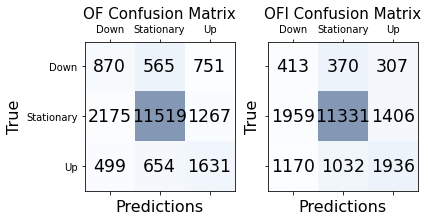

In [331]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
    
fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True)

mat_con1 = confusion_matrix(model_details['OF']['test_y'].argmax(axis=1), 
                           model_details['OF']['pred_y'].argmax(axis=1))
mat_con2 = confusion_matrix(model_details['OFI']['test_y'].argmax(axis=1), 
                           model_details['OFI']['pred_y'].argmax(axis=1))

for ax in zip((ax1,ax2),(mat_con1,mat_con2),('OF','OFI')):
    ax[0].matshow(ax[1], cmap=plt.cm.Blues, alpha=0.5)
    
    for m in range(ax[1].shape[0]):
        for n in range(ax[1].shape[1]):
            ax[0].text(x=m, y=n, s=ax[1][m, n], va='center', ha='center', size='xx-large')

    ax[0].set_xlabel('Predictions', fontsize=16)
    ax[0].set_ylabel('True', fontsize=16)
    plt.xticks(np.arange(3), ['Down', 'Stationary', 'Up'])
    plt.yticks(np.arange(3), ['Down', 'Stationary', 'Up'], rotation='vertical', va='center')
    ax[0].set_title(ax[2] + ' Confusion Matrix', fontsize=15)
    
fig.tight_layout()

The confusion matrices reinforce the fact that the order flow model makes better predictions. This is particularly the case when it comes to upward moves; the order flow model is more illiberal with its upward predictions, but the predictions it does make are clearly more in line with the true moves. On the other hand, both models are not good at predicting downward moves. This will likely be problematic in our trading scenario, since the Bitcoin mid price dropped by 1% over the course of the trading period we consider.

## Building a Trading Signal
To test this hypothesis, we compare two trading strategies using our test set as the trading period. We ignore transaction costs and close positions at the end of the trading period. For each timestamp we trade at, we go long or short $\mu$ Bitcoins, where $\mu$ is 30% of the volume at the first ask or bid level we enter at, respectively[<sub>[2]</sub>](#ref2).

### Softmax Trading Strategy
For this strategy, we choose a threshold probability $\alpha$ and go long if $\hat{p}_{1,t}>\alpha$ and go short if $\hat{p}_{-1,t}>\alpha$, where $\hat{p}_{1,t}$ is the predicted probability of an upward move at time $t$ and $\hat{p}_{-1,t}$ is the predicted probability of a downward move at time $t$. Only one position is allowed at any time. We store the cumulative profits and their ratios to transaction volume for a few threshold values.

In [603]:
alphas = [0.6,0.7,0.8]

for time_series in model_details:
    
    trading_period = lob_data.index[-len(model_details[time_series]['preds_mean']):]
    for a in alphas:
        
        position = None
        model_details[time_series]['softmax_returns_{}'.format(a)] = np.zeros(len(trading_period))
        pnl = 0
        num_trades = 0
        
        for t in trading_period:
            
            # Compute return at this timestamp
            if position == 'SHORT':
                model_details[time_series]['softmax_returns_{}'.format(a)][t-trading_period.start] = mu * (lob_data.PRICE_BID_0[t-1] - lob_data.PRICE_BID_0[t])
            elif position == 'LONG':
                model_details[time_series]['softmax_returns_{}'.format(a)][t-trading_period.start] = mu * (lob_data.PRICE_ASK_0[t] - lob_data.PRICE_ASK_0[t-1])
            
            if position != 'LONG' and np.argmax(model_details[time_series]['preds_mean'][t-trading_period.start]) == 2 and np.max(model_details[time_series]['preds_mean'][t-trading_period.start]) > a:
                # Set size if not yet specified
                if position == None:
                    mu = 0.3 * lob_data.VOLUME_ASK_0[t]
                # Record current price
                long_now = lob_data.PRICE_ASK_0[t]
                # Close short position
                if position == 'SHORT':
                    pnl += mu * (entry_last - long_now)
                # Enter long position
                entry_last = long_now
                position = 'LONG'
                num_trades += 1

            elif position != 'SHORT' and np.argmax(model_details[time_series]['preds_mean'][t-trading_period.start]) == 0 and np.max(model_details[time_series]['preds_mean'][t-trading_period.start]) > a:
                # Set size if not yet specified
                if position == None:
                    mu = 0.3 * lob_data.VOLUME_BID_0[t]
                # Record current price
                short_now = lob_data.PRICE_BID_0[t]
                # Close long position
                if position == 'LONG':
                    pnl += mu * (short_now - entry_last)
                # Enter short position
                entry_last = short_now
                position = 'SHORT'
                num_trades += 1
                
        # Close position
        if position == 'SHORT':
            long_now = lob_data.PRICE_ASK_0[trading_period.stop-1]
            model_details[time_series]['softmax_returns_{}'.format(a)][-1] = mu * (entry_last - long_now)
            pnl += mu * (entry_last - long_now)
            num_trades += 1
        elif position == 'LONG':
            short_now = lob_data.PRICE_BID_0[trading_period.stop-1]
            model_details[time_series]['softmax_returns_{}'.format(a)][-1] = mu * (short_now - entry_last)
            pnl += mu * (short_now - entry_last)
            num_trades += 1

        model_details[time_series]['softmax_profits_{}'.format(a)] = pnl
        model_details[time_series]['softmax_profits_normalized_{}'.format(a)] = pnl/num_trades


### Bayesian Trading Strategy
Now, how can we use uncertainty information to inform trading decisions? This strategy borrows BDLOB's use of *predictive [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory))* to summarize classification uncertainty due to variational dropout[<sub>[2]</sub>](#ref2). The metric of predictive entropy $\mathbb{H}$ follows from our aforementioned understanding of conditional expectation by making use of the predictive distribution captured by our 100 forward passes from earlier. For an input $x_t$, a predicted output $y_t$, training data $\mathcal{D}_{\text{train}}$, and estimated model parameters $\hat{w}$, we define predictive entropy by
$$
\begin{equation}
     \begin{aligned}
     \mathbb{H}(y_{t}|x_{t},\mathcal{D}_{\text{train}}) &= -\sum_{j=-1}^{1} p(y_{t}=j|x_{t},\mathcal{D}_{\text{train}})\log p(y_{t}=j|x_{t},\mathcal{D}_{\text{train}}) \\
    &\approx -\sum_{j=-1}^{1} \left( \frac{1}{100}\sum_{k=1}^{100} p(y_{t}=j|x_{t},\hat{w})\right) \log \left(\frac{1}{100}\sum_{k=1}^{100} p(y_{t}=j|x_{t},\hat{w})\right) \\
    &=: \tilde{\mathbb{H}}_t.
    \end{aligned}
\end{equation}
$$

Essentially, $j$ iterates over each class and summarizes the average level of uncertainty for outcomes of that class. The function is minimized when the model is certain––when one class has probability 1 and all others are 0. The function is maximized when the model is very uncertain––probability is uniform across the classes. Also observe that our earlier notation $\hat{p}_{j,t}$ is shorthand for $\frac{1}{100}\sum_{k=1}^{100} p(y_{t}=j|x_{t},\hat{w})$.

Using this metric, we upsize our positions if our model is certain and downsize our positions if the model is uncertain. More specifically, we still go long or short if $\hat{p}_{1,t}>\alpha$ or $\hat{p}_{-1,t}>\alpha$, respectively, but we upsize our positions to $1.5 \times \mu$ if $\tilde{\mathbb{H}}_t<\beta_1$, keep our size $\mu$ if $\beta_1< \tilde{\mathbb{H}}_t < \beta_2$, downsize to $0.5 \times \mu$ if $\tilde{\mathbb{H}}_t>\beta_2$, and exit the current position if $\tilde{\mathbb{H}}_t < \beta_2$[<sub>[2]</sub>](#ref2). We fix values for $\alpha$ and $\beta_2$ and test different values for $\beta_1$.

In [547]:
threshold = 0.7
beta1 = [0.1,0.2,0.3]
beta2 = 0.7

for time_series in model_details:
    trading_period = lob_data.index[-len(model_details[time_series]['preds_mean']):]
    for b1 in beta1:
        
        position = None
        model_details[time_series]['bayesian_returns_({b1},{b2})'.format(b1=b1,b2=beta2)] = np.zeros(len(trading_period))
        pnl = 0
        num_trades = 0

        for t in trading_period:
            
            entropy = -np.sum(np.max(model_details[time_series]['preds_mean'][t-trading_period.start])*
                              np.log(np.max(model_details[time_series]['preds_mean'][t-trading_period.start])))
            
            # Compute return at this timestamp
            if position == 'SHORT':
                model_details[time_series]['bayesian_returns_({b1},{b2})'.format(b1=b1,b2=beta2)][t-trading_period.start] = size * (lob_data.PRICE_ASK_0[t-1] - lob_data.PRICE_ASK_0[t])
            elif position == 'LONG':
                model_details[time_series]['bayesian_returns_({b1},{b2})'.format(b1=b1,b2=beta2)][t-trading_period.start] = size * (lob_data.PRICE_BID_0[t] - lob_data.PRICE_BID_0[t-1])
            
            if position != 'LONG' and np.argmax(model_details[time_series]['preds_mean'][t-trading_period.start]) == 2 and np.max(model_details[time_series]['preds_mean'][t-trading_period.start]) > threshold:
                # Set size if not yet specified
                if position == None:
                    mu = 0.3 * lob_data.VOLUME_ASK_0[t]
                # Record current price
                long_now = lob_data.PRICE_ASK_0[t]
                
                if b1 < entropy < beta2:
                    # Close short position
                    if position == 'SHORT':
                        pnl += size * (entry_last - long_now)
                    # Enter long position
                    entry_last = long_now
                    position = 'LONG'
                    size = mu
                    num_trades += 1
                    
                elif entropy < b1:
                    # Close short position
                    if position == 'SHORT':
                        pnl += size * (entry_last - long_now)
                    # Enter upsized long position
                    entry_last = long_now
                    position = 'LONG'
                    size = 1.5 * mu
                    num_trades += 1
                    
                else: # entropy > beta2
                    # Enter upsized long position
                    entry_last = long_now
                    position = 'LONG'
                    size = 0.5 * mu
                    num_trades += 1
                    
            elif position != 'SHORT' and np.argmax(model_details[time_series]['preds_mean'][t-trading_period.start]) == 0 and np.max(model_details[time_series]['preds_mean'][t-trading_period.start]) > threshold:
                # Set size if not yet specified
                if position == None:
                    mu = 0.3 * lob_data.VOLUME_BID_0[t]
                # Record current price
                short_now = lob_data.PRICE_BID_0[t]
                
                if b1 < entropy < beta2:
                    # Close long position
                    if position == 'LONG':
                        pnl += size * (short_now - entry_last)
                    # Enter short position
                    entry_last = short_now
                    position = 'SHORT'
                    size = mu
                    num_trades += 1
                
                elif entropy < b1:
                    # Close long position
                    if position == 'LONG':
                        pnl += size * (short_now - entry_last)
                    # Enter upsized short position
                    entry_last = short_now
                    position = 'SHORT'
                    size = 1.5 * mu
                    num_trades += 1
                
                else: # entropy > beta2
                    # Enter downsized short position
                    entry_last = short_now
                    position = 'SHORT'
                    size = 0.5 * mu
                    num_trades += 1
                
         # Close position
        if position == 'SHORT':
            long_now = lob_data.PRICE_ASK_0[trading_period.stop-1]
            model_details[time_series]['bayesian_returns_({b1},{b2})'.format(b1=b1,b2=beta2)][-1] = size * (entry_last - long_now)
            pnl += size * (entry_last - long_now)
            num_trades += 1
        elif position == 'LONG':
            short_now = lob_data.PRICE_BID_0[trading_period.stop-1]
            model_details[time_series]['bayesian_returns_({b1},{b2})'.format(b1=b1,b2=beta2)][-1] = size * (short_now - entry_last)
            pnl += size * (short_now - entry_last)
            num_trades += 1
                     
        model_details[time_series]['bayesian_profits_({b1},{b2})'.format(b1=b1,b2=beta2)] = pnl
        model_details[time_series]['bayesian_profits_normalized_({b1},{b2})'.format(b1=b1,b2=beta2)] = pnl/num_trades
            

### Results
Now comes the question of how we should compare these strategies in terms of profit and risk. 

Since each strategy returns different transaction volumes, we standardize profits to properly compare profitability. And while the [Sharpe ratio](https://en.wikipedia.org/wiki/Sharpe_ratio) is a popular measure of risk in a portfolio or strategy, it deems large positive and negative returns to be equally risky, so we follow BDLOB[<sub>[2]</sub>](#ref2) in using the Downward Deviation ratio $ \text{DDR} = \frac{E(R_t)}{\text{DD}_T} $ as our risk measure, where $E(R_t)$ is the average return per timestamp and $\text{DD}_T=\sqrt{\frac{1}{T} \sum_{t=1}^T \text{min}(R_t,0)^2}$ measures the deviation of negative returns. DDR, which is essentially the [Sortino ratio](https://en.wikipedia.org/wiki/Sortino_ratio) with a target rate of 0, has the desired property of penalizing negative returns and rewarding positive returns.

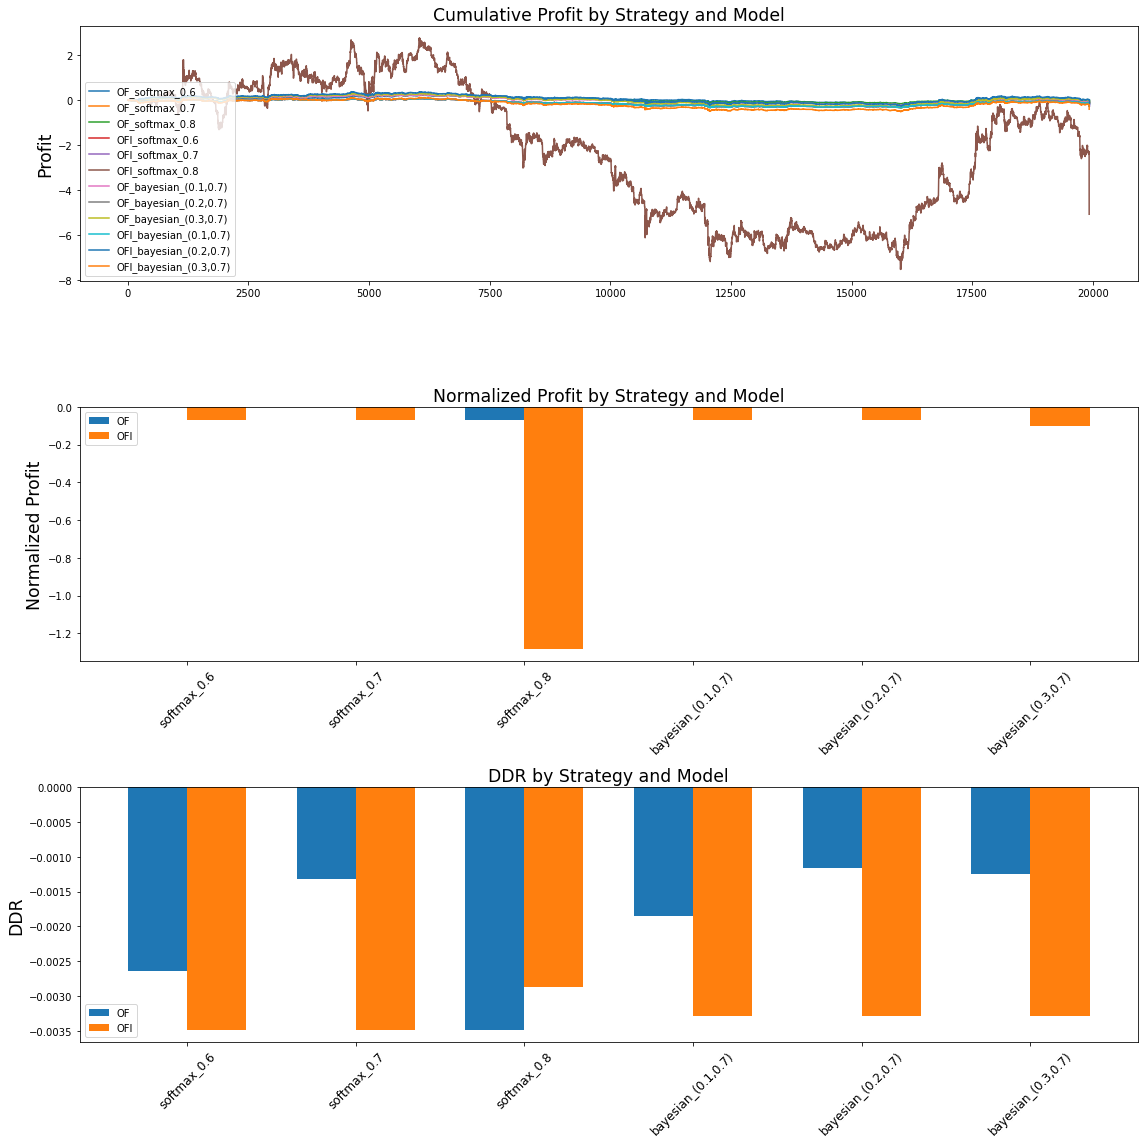

In [605]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['softmax_{}'.format(a) 
          for a in alphas] + ['bayesian_({b1},{b2})'.format(b1=b1,b2=beta2) 
                              for b1 in beta1]
returns = [model_details[time_series]['softmax_returns_{}'.format(a)] 
           for a in alphas for time_series in model_details] + [model_details[time_series]['bayesian_returns_({b1},{b2})'.format(b1=b1,b2=beta2)] 
                                                                for b1 in beta1 for time_series in model_details]
            
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,16))
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Plot Cumulative Profit
for ret in zip(returns,['OF']*3+['OFI']*3+['OF']*3+['OFI']*3,labels[:3]*2+labels[3:]*2):
    ax1.plot(ret[0].cumsum(),label=ret[1]+'_'+ret[2])
ax1.set_ylabel('Profit', size='xx-large')
ax1.set_title('Cumulative Profit by Strategy and Model', size='xx-large')
ax1.legend(loc='best')

# Plot Normalized Profit
of_profits_normalized = [model_details['OF']['softmax_profits_normalized_{}'.format(a)] 
                         for a in alphas] + [model_details['OF']['bayesian_profits_normalized_({b1},{b2})'.format(b1=b1,b2=beta2)] 
                                             for b1 in beta1]
ofi_profits_normalized = [model_details['OFI']['softmax_profits_normalized_{}'.format(a)] 
                          for a in alphas] + [model_details['OFI']['bayesian_profits_normalized_({b1},{b2})'.format(b1=b1,b2=beta2)] 
                                              for b1 in beta1]
    
ax2.bar(x - width/2, of_profits_normalized, width, label='OF')
ax2.bar(x + width/2, ofi_profits_normalized, width, label='OFI')  

ax2.set_ylabel('Normalized Profit', size='xx-large')
ax2.set_title('Normalized Profit by Strategy and Model', size='xx-large')
ax2.set_xticks(x, labels, rotation=45, size='large')
ax2.legend(loc='best')

# Plot DDR
of_ddr = [model_details['OF']['softmax_returns_{}'.format(a)].mean() / 
np.sqrt((model_details['OF']['softmax_returns_{}'.format(a)][model_details['OF']['softmax_returns_{}'.format(a)] < 0]**2).mean())
 for a in alphas] + [model_details['OF']['bayesian_returns_({b1},{b2})'.format(b1=b1,b2=beta2)].mean() / 
np.sqrt((model_details['OF']['bayesian_returns_({b1},{b2})'.format(b1=b1,b2=beta2)][model_details['OF']['bayesian_returns_({b1},{b2})'.format(b1=b1,b2=beta2)] < 0]**2).mean())
 for b1 in beta1]
ofi_ddr = [model_details['OFI']['softmax_returns_{}'.format(a)].mean() / 
np.sqrt((model_details['OFI']['softmax_returns_{}'.format(a)][model_details['OFI']['softmax_returns_{}'.format(a)] < 0]**2).mean())
 for a in alphas] + [model_details['OFI']['bayesian_returns_({b1},{b2})'.format(b1=b1,b2=beta2)].mean() / 
np.sqrt((model_details['OFI']['bayesian_returns_({b1},{b2})'.format(b1=b1,b2=beta2)][model_details['OFI']['bayesian_returns_({b1},{b2})'.format(b1=b1,b2=beta2)] < 0]**2).mean())
 for b1 in beta1]

ax3.bar(x - width/2, of_ddr, width, label='OF')
ax3.bar(x + width/2, ofi_ddr, width, label='OFI')  

ax3.set_ylabel('DDR', size='xx-large')
ax3.set_title('DDR by Strategy and Model', size='xx-large')
ax3.set_xticks(x, labels, rotation=45, size='large')
ax3.legend(loc='best')

plt.tight_layout()
plt.show()


Unfortunately, the models were both very poor in their ability to generate profits, but this should come as no surprise. Recall that our models predict downward moves almost identically poorly, so it is reasonable to believe that the model is doomed to behave poorly in a downward trending regime. And since the Bitcoin mid price dropped 1% over the duration of the trading period, our understanding of the model justify the results we see. 

Although the losses are very disappointing, there are still valuable observations that can be made. Firstly, we see in the plot of cumulative profits that the returns––or lack of returns––from the Bayesian trading strategy are mostly steady about 0, while the softmax strategy returns are more erratic. And while the quantities are negative, the normalized profit and DDR grouped bar charts clearly illustrate the benefit that training on order flow offered over order flow imbalance.

With access to more data, stress testing the model in different market regimes would be an interesting future direction to study to further deduce the model's empirical soundness.

Also, it may very well be the case that this model is very popular, and any potential profits have been arbitraged out.

# Model Diagnostics
To be in acccordance with the Box-Jenkins approach, we test the fitted models' residuals $\left\{\hat{u}_i\right\}_{i=1}^{T}$ for any [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)—that is, we check whether residuals are correlated to past residuals in the sequence. If true, there is statistical evidence that the model is underfitting, and we should increase the lag parameter of our sequential model and re-train. If false, we accept the model residuals to be [white noise](https://en.wikipedia.org/wiki/White_noise). 

We compute our residuals as the [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) of the classification problem at each timestamp, which we define by
$$ \hat{u}_i=-\sum_{j=-1}^{1}y_i(j)\log\hat{y}_i(j) $$
for $i\in\left\{1,...,T\right\}$, where $y_i$ is the [one-hot encoded](https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics) 3-variable vector of the true 1-step movement, $\hat{y}_i$ is our model's unrounded prediction of that encoding, and $T$ is the number of observations.

Letting $\hat{\tau}_i$ be the sample autocorrelations of the residuals and $m$ to be a maximum lag to test, we use the Ljung-Box statistic
$$ Q(m) = T(T+2)\sum_{l=1}^{m}\frac{\hat{\tau}_l^2}{T-l} $$
as our test statistic for the null hypothesis $H_0: \tau_1=...=\tau_m=0$ versus the alternative $H_a: \tau_i\neq0$ for some $i\in\left\{1,...,m\right\}$. For large $T$, the statistic is [chi-squared distributed](https://en.wikipedia.org/wiki/Chi-squared_distribution) with $m$ degrees of freedom, and we reject the null in favor of the alternative if the test statistic is greater than the critical value of the corresponding chi-squared distribution at the 99% confidence level. 

In [407]:
from statsmodels.stats.diagnostic import acorr_ljungbox

with device('cpu:0'):
    for time_series in model_details:
        residuals = -np.sum(model_details[time_series]['train_y']*
                           np.log(model_details[time_series]['model'].predict(model_details[time_series]['train_x'])),
                           axis=1)
        lb, p = acorr_ljungbox(residuals, lags=100, boxpierce=False, return_df=False)
        if len(p[p < 0.01]) > 0:
            print(time_series + " is underfitting.")
        else:
            print(time_series + " is not underfitting.")


OF is underfitting.
OFI is underfitting.


Unfortunately, we conclude that both models are underfitting the training data, so we should increase the lag parameter and redo the training and diagnostics until we no longer underfit. However, we don't pursue this route for a few reasons. For one, while increasing the lag does not lead to any risk of overfitting the deep learning model, doing so increases computational time[<sup>5</sup>](#fn5). With the current lag, iterating through the cross-validation and training takes many many hours already, and I'm antsy to finish this project. Secondly, Kolm et al[<sub>[4]</sub>](#ref4) found that different choices for the lag parameter had little impact on the performance of the CNN-LSTM model for their regression problem. And as a third point, the fact that the model is underfitting should come as no surprise, since this really tells us that our model is too simple for the data. Financial data, even such stationary processes as order flow and order flow imbalance, are incredibly complex, so it's hard to expect any interpretable model to well-fit the input data. In this truth lies one of the problems of deep learning in finance.

<sup>5. </sup><span id="fn5"><sup>Surakhi et al[<sub>[11]</sub>](#ref11) compare three ways to choose the lag parameter of a time series forecast and find that autocorrelation is maybe not the best approach. In a future time series analysis, I think I might dive into such methodologies.</sup></span>

## Shortfalls of Deep Learning
Machine learning models are able to identify patterns in data even where there are none. In finance, where anomalous features in datasets can be frequent, this underlying mechanism can lead to misidentified strategies and be very costly if the model implementation, validation, and utilization is not approached with caution. 

Moreover, markets are always changing, and static models such as our CNN-LSTM are trained on a security's characteristics during one market state. Hence, the sustainability of such a model in out-of-time samples is a concern, and constant fine-tuning can be expensive and represent a suboptimal allocation of resources for a trader.

Nonetheless, I find the topic really cool and believe it to be a valuable use of my study time.

## Conclusion
In this notebook, we implemented a well-studied and popular deep learning model with the intent of forecasting the mid price of the limit order book and comparing model performance on a pair of related stationary inputs. We found that when trained on a sparse amount of data, the models predicted downward moves in the target mid price awfully, which led to losing trading attempts in two strategies. The analysis was not all for naught, however: the order flow model outperformed the order flow imbalance model in upward moves, and utilizing uncertainty information in a trading strategy led to less erratic cumulative profits on average. I also believe that showcasing the models' lack of success in a bearish market was a valuable informal stress test for the model.

Thank you to Moritz Voss for pushing me to pursue this project and to the many researchers whom I reference below.

## References
1. <span id="ref1">Zhang, Zihao, Stefan Zohren, and Stephen Roberts (2019). “DeepLOB: Deep Convolutional Neural Networks for Limit Order Books”. In: *IEEE Transactions On Signal Processing* 67.11, pp. 3001–3012.<br>
2. <span id="ref2">Zhang, Zihao, Stefan Zohren, and Stephen Roberts (2018). “BDLOB: Bayesian Deep Convolutional Neural Networks For Limit Order Books”. In: *arXiv preprint arXiv:1811.10041*.<br>
3. <span id="ref3">Cont, Rama, Arseniy Kukanov, and Sasha Stoikov (2014). “The Price Impact Of
Order Book Events”. In: *Journal Of Financial Econometrics* 12.1, pp. 47–88.<br>
4. <span id="ref4">Kolm, Petter, Jeremy Turiel, and Nicholas Westray (2021). "Deep Order Flow Imbalance: Extracting Alpha At Multiple Horizons From The Limit Order Book". In: *Available at SSRN 3900141*.<br>
5. <span id="ref5">Lütkepohl, Helmut (2005). *New Introduction to Multiple Time Series Analysis*. Springer.<br> 
6. <span id="ref6">Dixon, Matthew F., Igor Halperin, and Paul Bilokon (2020). *Machine Learning in Finance: From Theory to Practice*. Springer.<br>
7. <span id="ref7">Hochreiter, Sepp and Jürgen Schmidhuber (1997). “Long Short-Term Memory”. In: *Neural Computation* 9.8, pp. 1735–1780.<br>
8. <span id="ref8">Ntakaris, Adamantios, Martin Magris, Juho Kanniainen, Moncef Gabbouj, and Alexandros Iosifidis (2018). “Benchmark Dataset For Mid-Price Forecasting Of Limit Order Book Data With Machine Learning Methods”. In: *Journal of Forecasting* 37.8, pp. 852–866.<br>
9. <span id="ref9">Yang, Kiyoung, and Cyrus Shahabi (2005). "On the Stationarity of Multivariate Time Series for Correlation-Based Data Analysis". In: *Fifth IEEE International Conference on Data Mining*, pp. 1-4.<br>
10. <span id="ref10">Gal, Yarin (2016). *Uncertainty in Deep Learning*. Phd Thesis, University of Cambridge.<br>
11. <span id="ref11">Surakhi, Ola, Martha A. Zaidan, Pak Lun Fung, Naser Hossein Motlagh, Sami Serhan, Mohammad AlKhanafseh, Rania M. Ghoniem, and Tareq Hussein (2021). "Time-Lag Selection for Time-Series Forecasting Using Neural Network and Heuristic Algorithm". In: *Electronics* 10.20.<br>